In [18]:
import numpy as np
import pandas as pd
from oemof import solph
from dash import html, dcc, Dash
import plotly.graph_objects as go

try:
    from oemof_visio import ESGraphRenderer

    ES_GRAPH = True
except ModuleNotFoundError:
    ES_GRAPH = False

from main import (
    generate_blackout_events,
    compute_blackout_kpis,
    DEFAULT_DAILY_LIKELIHOOD,
    process_daily_likelihood,
)


NIGHT = "night"
EVENING = "evening"
AFTERNOON = "afternoon"
MIDDAY = "midday"
MORNING = "morning"


def time_category(hour):
    if 0 <= hour < 6 or 20 <= hour <= 24:
        answer = NIGHT
    elif 6 <= hour < 11:
        answer = MORNING
    elif 11 <= hour < 14:
        answer = MIDDAY
    elif 14 <= hour < 17:
        answer = AFTERNOON
    elif 17 <= hour < 20:
        answer = EVENING
    return answer


average_frequency = 45
std_frequency = 0
average_duration = 3
std_duration = 0.1

evaluated_days = 365
date_time_index = pd.date_range(
    start="2024-01-01", freq="h", periods=evaluated_days * 24
)

input_daily_likelihood = {
    (0, 6): 9,
    (6, 11): 10,
    (11, 14): 20,
    (14, 17): 8,
    (17, 20): 15,
    (20, 24): 9,
}


def compare_input_and_simulated(input_daily_likelihood, average_duration):
    (
        grid_availability,
        blackout_events_duration,
        overlapping_blackouts,
        blackout_count,
    ) = generate_blackout_events(
        average_frequency,
        average_duration,
        date_time_index,
        daily_likelihood=input_daily_likelihood,
    )

    print(
        f"In total there are {blackout_count} individual blackouts and {overlapping_blackouts} overlapping blackouts, so {blackout_count+overlapping_blackouts} event where initially generated"
    )

    # prepare data for input weights histogram
    input_daily_likelyhood = pd.DataFrame(
        pd.Series(
            [i for i in process_daily_likelihood(input_daily_likelihood).values()],
            name="input",
        )
    )
    input_daily_likelyhood["period"] = input_daily_likelyhood.index.map(time_category)
    input_daily_likelyhood.groupby("period").sum()
    input_daily_likelyhood = (
        input_daily_likelyhood.groupby("period").sum()
        / input_daily_likelyhood.groupby("period").sum().sum()
    )

    # prepare data for simulated blackout histograms
    blackouts_per_period = pd.DataFrame(
        pd.Series(
            1,
            index=grid_availability.loc[grid_availability == 0].index,
            name="simulated",
        )
    )

    blackouts_per_period["period"] = grid_availability.loc[
        grid_availability == 0
    ].index.hour.map(time_category)
    if average_duration is None:
        assert (
            blackout_count + overlapping_blackouts
            == blackouts_per_period.groupby("period").sum().sum().values[0]
        )
    daily_likelihood_experimental = (
        blackouts_per_period.groupby("period").sum()
        / blackouts_per_period.groupby("period").sum().sum()
    )
    daily_likelihood_experimental["user input"] = input_daily_likelyhood.input

    compute_blackout_kpis(
        grid_availability,
        blackout_events_duration,
        overlapping_blackouts,
        blackout_count,
        plot=False,
    )

    return daily_likelihood_experimental, grid_availability

Here we can play with different input daily_likelihoods

In [2]:
daily_likelihoods = [
    {
        (0, 6): 9,
        (6, 11): 10,
        (11, 14): 40,
        (14, 17): 8,
        (17, 20): 15,
        (20, 24): 9,
    },
    {
        (0, 6): 9,
        (6, 11): 10,
        (11, 14): 4,
        (14, 17): 8,
        (17, 20): 15,
        (20, 24): 9,
    },
    {
        (0, 6): 9,
        (6, 11): 10,
        (11, 14): 0,
        (14, 17): 8,
        (17, 20): 0,
        (20, 24): 9,
    },
]

here we look at the whole simulated blackout duration, not only when the blackout starts

Accumulated blackout duration: 1687.653
Accumulated blackout duration (rounded to timestep): 1678.0
463 simulated    1555
dtype: int64
Due to 98 overlapping blackouts, the total random blackout duration (1678.0) is not equal with the real grid unavailability (1555).
Grid is not operational for 1555 hours out of 8760, with a reliability of 82.25 percent. 

Accumulated blackout duration: 1647.638
Accumulated blackout duration (rounded to timestep): 1655.0
455 simulated    1557
dtype: int64
Due to 95 overlapping blackouts, the total random blackout duration (1655.0) is not equal with the real grid unavailability (1557).
Grid is not operational for 1557 hours out of 8760, with a reliability of 82.23 percent. 

Accumulated blackout duration: 1660.344
Accumulated blackout duration (rounded to timestep): 1651.0
447 simulated    1526
dtype: int64
Due to 105 overlapping blackouts, the total random blackout duration (1651.0) is not equal with the real grid unavailability (1526).
Grid is not oper

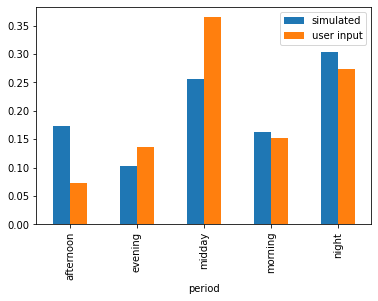

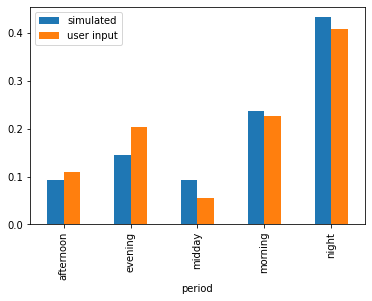

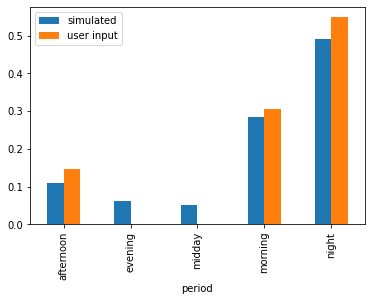

In [6]:
for d in daily_likelihoods:
    df, ga = compare_input_and_simulated(d, average_duration=average_duration)
    df.plot.bar()

# here we look only when the blackout starts to compare to initial probability distribution

## sanity_checks
- when weight is set to 0 --> there is no event within the weight time period

## current issues 
- the histogram should match one to one if standard deviation is set to 0 the maybe the time_category function does not bin the events in the right category? and therefore we see a disparity here?

In total there are 491 individual blackouts and 42 overlapping blackouts, so 533 event where initially generated
Grid is not operational for 533 hours out of 8760, with a reliability of 93.92 percent. 

In total there are 491 individual blackouts and 27 overlapping blackouts, so 518 event where initially generated
Grid is not operational for 518 hours out of 8760, with a reliability of 94.09 percent. 

In total there are 500 individual blackouts and 36 overlapping blackouts, so 536 event where initially generated
Grid is not operational for 536 hours out of 8760, with a reliability of 93.88 percent. 



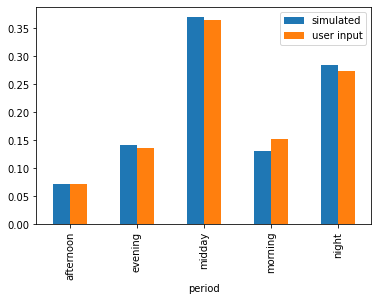

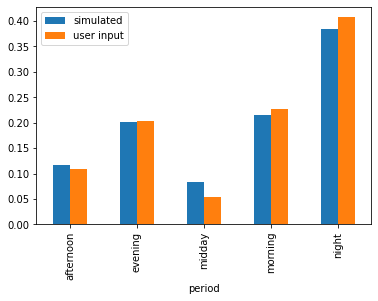

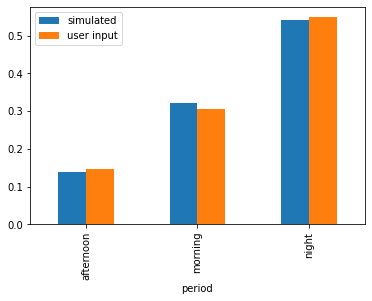

In [19]:
for d in daily_likelihoods:
    df, ga = compare_input_and_simulated(d, average_duration=None)
    df.plot.bar()